In [5]:
# Ноутбук для модели MLP по предсказыванию следующего слова
# https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
# https://www.youtube.com/watch?v=TCH_1BHY58I

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# Загрузим данные

In [3]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [7]:
len(words)

32033

In [6]:
# построим словарь отображения из букв в индексы
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
# и наоборот
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [9]:
# построим датасет
block_size = 3  # длина контекста: сколько букв учитывать при предсказании следующей буквы
X, Y = [], []
for w in words[:5]:

    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]  # обрезаем и добавляем

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [12]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

# Работа с эмбеддингами

In [13]:
# построим эмбеддинги
C = torch.randn((27, 2))  # для примера размера 2 для 27 букв
C

tensor([[-2.2038,  0.2901],
        [ 0.4239,  0.0915],
        [ 0.2723,  1.2391],
        [ 0.0567,  0.7284],
        [ 0.6097,  0.9417],
        [ 0.4509, -0.4534],
        [-0.6766, -1.1069],
        [-0.0983,  0.2916],
        [-0.7061,  1.2662],
        [ 0.6173, -0.0921],
        [ 1.0764,  0.0791],
        [-0.1550, -0.5481],
        [ 0.8487,  1.7650],
        [ 0.3184, -0.5896],
        [ 0.8741, -0.7672],
        [ 0.5559, -0.8338],
        [ 0.6738, -1.6116],
        [ 0.9502,  0.5238],
        [-1.6098, -0.6290],
        [ 0.8511, -0.6852],
        [-0.5753, -2.0240],
        [ 0.1643, -2.3471],
        [-1.8288,  1.2308],
        [-0.5702, -0.8799],
        [ 1.1368, -0.2751],
        [-0.0327,  1.1446],
        [-0.0116, -0.7773]])

In [14]:
C[5]

tensor([ 0.4509, -0.4534])

In [18]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C  # альтернатива эмбеддингам
# На самом деле получается, что слой эмбеддинга - это просто слов нейронной сети, с весами C (самими эмбеддингами)
# И на вход мы также подаем one hot векторы и умножаем на матрицу весов, чтобы достать нужный эмбеддинг
# Но брать индекс (как C[5]) просто быстрее, а так - все аналогично

tensor([ 0.4509, -0.4534])

In [19]:
C[[5, 6, 7]]  # можно много

tensor([[ 0.4509, -0.4534],
        [-0.6766, -1.1069],
        [-0.0983,  0.2916]])

In [23]:
# Или вообще наш датасет может быть индексом
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

# Работа со скрытым слоем нейронной сети

In [21]:
W1 = torch.randn((6, 100))  # 100 нейронов для примера, вход 3 слова по 2 размерности
b1 = torch.randn(100)

In [28]:
# Но сейчас не сработает матричное умножение emb @ W1, потому что размер emb -> [32, 3, 2], а W1 -> [6, 100]
# Надо как-то склеить эмбеддинги, torch.cat
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1)

tensor([[-2.2038,  0.2901, -2.2038,  0.2901, -2.2038,  0.2901],
        [-2.2038,  0.2901, -2.2038,  0.2901,  0.4509, -0.4534],
        [-2.2038,  0.2901,  0.4509, -0.4534,  0.3184, -0.5896],
        [ 0.4509, -0.4534,  0.3184, -0.5896,  0.3184, -0.5896],
        [ 0.3184, -0.5896,  0.3184, -0.5896,  0.4239,  0.0915],
        [-2.2038,  0.2901, -2.2038,  0.2901, -2.2038,  0.2901],
        [-2.2038,  0.2901, -2.2038,  0.2901,  0.5559, -0.8338],
        [-2.2038,  0.2901,  0.5559, -0.8338,  0.8487,  1.7650],
        [ 0.5559, -0.8338,  0.8487,  1.7650,  0.6173, -0.0921],
        [ 0.8487,  1.7650,  0.6173, -0.0921, -1.8288,  1.2308],
        [ 0.6173, -0.0921, -1.8288,  1.2308,  0.6173, -0.0921],
        [-1.8288,  1.2308,  0.6173, -0.0921,  0.4239,  0.0915],
        [-2.2038,  0.2901, -2.2038,  0.2901, -2.2038,  0.2901],
        [-2.2038,  0.2901, -2.2038,  0.2901,  0.4239,  0.0915],
        [-2.2038,  0.2901,  0.4239,  0.0915, -1.8288,  1.2308],
        [ 0.4239,  0.0915, -1.8288,  1.2

In [30]:
torch.unbind(emb, dim=1)  # получаем список без определенной оси

(tensor([[-2.2038,  0.2901],
         [-2.2038,  0.2901],
         [-2.2038,  0.2901],
         [ 0.4509, -0.4534],
         [ 0.3184, -0.5896],
         [-2.2038,  0.2901],
         [-2.2038,  0.2901],
         [-2.2038,  0.2901],
         [ 0.5559, -0.8338],
         [ 0.8487,  1.7650],
         [ 0.6173, -0.0921],
         [-1.8288,  1.2308],
         [-2.2038,  0.2901],
         [-2.2038,  0.2901],
         [-2.2038,  0.2901],
         [ 0.4239,  0.0915],
         [-2.2038,  0.2901],
         [-2.2038,  0.2901],
         [-2.2038,  0.2901],
         [ 0.6173, -0.0921],
         [ 0.8511, -0.6852],
         [ 0.4239,  0.0915],
         [ 0.2723,  1.2391],
         [ 0.4509, -0.4534],
         [ 0.8487,  1.7650],
         [-2.2038,  0.2901],
         [-2.2038,  0.2901],
         [-2.2038,  0.2901],
         [ 0.8511, -0.6852],
         [ 0.5559, -0.8338],
         [ 0.6738, -1.6116],
         [-0.7061,  1.2662]]),
 tensor([[-2.2038,  0.2901],
         [-2.2038,  0.2901],
         [ 0

In [32]:
torch.cat(torch.unbind(emb, dim=1), dim=1)

tensor([[-2.2038,  0.2901, -2.2038,  0.2901, -2.2038,  0.2901],
        [-2.2038,  0.2901, -2.2038,  0.2901,  0.4509, -0.4534],
        [-2.2038,  0.2901,  0.4509, -0.4534,  0.3184, -0.5896],
        [ 0.4509, -0.4534,  0.3184, -0.5896,  0.3184, -0.5896],
        [ 0.3184, -0.5896,  0.3184, -0.5896,  0.4239,  0.0915],
        [-2.2038,  0.2901, -2.2038,  0.2901, -2.2038,  0.2901],
        [-2.2038,  0.2901, -2.2038,  0.2901,  0.5559, -0.8338],
        [-2.2038,  0.2901,  0.5559, -0.8338,  0.8487,  1.7650],
        [ 0.5559, -0.8338,  0.8487,  1.7650,  0.6173, -0.0921],
        [ 0.8487,  1.7650,  0.6173, -0.0921, -1.8288,  1.2308],
        [ 0.6173, -0.0921, -1.8288,  1.2308,  0.6173, -0.0921],
        [-1.8288,  1.2308,  0.6173, -0.0921,  0.4239,  0.0915],
        [-2.2038,  0.2901, -2.2038,  0.2901, -2.2038,  0.2901],
        [-2.2038,  0.2901, -2.2038,  0.2901,  0.4239,  0.0915],
        [-2.2038,  0.2901,  0.4239,  0.0915, -1.8288,  1.2308],
        [ 0.4239,  0.0915, -1.8288,  1.2

In [33]:
# еще один способ
a = torch.arange(18)
print(a.shape)
print(a.view(9, 2).shape)  # эффективная работа, потому что она не затрагивает память, а только отображение a.storage()
# http://blog.ezyang.com/2019/05/pytorch-internals/

torch.Size([18])
torch.Size([9, 2])


In [35]:
emb.view(32, 6) == torch.cat(torch.unbind(emb, dim=1), dim=1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [39]:
# в итоге меняем размерности и все работает
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[-0.5888, -0.9997, -1.0000,  ...,  1.0000, -0.4958, -0.4648],
        [-0.9994, -0.8184, -0.9999,  ...,  0.9992, -0.0775,  0.9983],
        [ 0.9010,  0.8412, -0.9861,  ..., -0.7779, -0.1909,  0.9880],
        ...,
        [ 0.9518, -0.9892, -0.9853,  ..., -0.9978,  0.9842, -0.8507],
        [-0.9983,  0.7559, -0.5938,  ...,  0.7552,  0.9960,  0.7286],
        [-0.7700,  0.9762,  0.9014,  ..., -0.9963,  0.0708,  0.9960]])

In [40]:
W2 = torch.randn((100, 27))  # 27 нейронов на выход
b2 = torch.randn(27)

In [41]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [42]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob

tensor([[5.0403e-10, 9.5757e-13, 3.5456e-09, 3.3414e-08, 1.5808e-04, 7.6414e-14,
         1.5424e-06, 7.9149e-13, 8.7383e-06, 2.0058e-13, 3.6748e-11, 2.2830e-04,
         1.5100e-10, 4.2172e-13, 8.3200e-15, 5.8596e-10, 2.9456e-02, 3.2568e-06,
         9.6804e-01, 5.4634e-07, 1.0011e-12, 8.6778e-12, 4.6470e-06, 2.0999e-03,
         6.3928e-15, 1.1539e-08, 1.1747e-12],
        [1.8309e-10, 4.4297e-14, 2.8079e-12, 3.2641e-10, 3.1050e-08, 1.3027e-12,
         5.3932e-06, 3.5588e-10, 1.2411e-04, 4.9757e-17, 9.9611e-09, 6.3334e-01,
         1.1992e-08, 2.4746e-10, 8.9950e-13, 6.0719e-10, 1.9919e-04, 2.4520e-13,
         3.0009e-06, 1.4787e-08, 1.1384e-09, 5.5553e-13, 3.6043e-01, 5.8972e-03,
         1.6598e-08, 2.0085e-06, 4.0353e-09],
        [5.6160e-09, 4.4981e-15, 2.4369e-13, 6.2776e-18, 7.6294e-12, 3.9087e-10,
         2.7252e-03, 2.2703e-12, 4.2615e-07, 9.4854e-18, 4.0503e-12, 1.9769e-06,
         3.5781e-15, 3.3961e-09, 4.6301e-14, 8.3575e-15, 1.3604e-11, 3.3925e-07,
         8.4472e-

In [43]:
# теперь нужно взять идекс настоящей буквы, идущей после нашего входа
prob[torch.arange(32), Y]  # в идеале они все должны быть 1 для обученной сети

tensor([7.6414e-14, 2.4746e-10, 3.3961e-09, 1.7191e-05, 8.1022e-08, 5.8596e-10,
        2.5516e-08, 1.0404e-09, 2.9295e-09, 8.8784e-02, 2.8979e-08, 3.1118e-08,
        9.5757e-13, 6.4912e-01, 1.2282e-10, 1.3221e-05, 2.0058e-13, 8.0694e-09,
        2.4118e-14, 1.6679e-02, 1.2734e-10, 4.1121e-09, 1.7286e-06, 2.6497e-09,
        1.0335e-03, 5.4634e-07, 6.1459e-10, 1.7906e-13, 8.9928e-07, 9.9996e-01,
        1.1075e-03, 9.6315e-04])

In [44]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(16.7307)

# Соберем все вместе

In [45]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [46]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2) , generator=g)  # embeddings
W1 = torch.randn((6, 100) , generator=g)  # weights of 1 layer
b1 = torch.randn(100 , generator=g)  # bias of 1 layer
W2 = torch.randn((100, 27) , generator=g)  # weights of 2 layer
b2 = torch.randn(27 , generator=g)  # bias of 2 layer
parameters = [C, W1, b1, W2, b2]  # all the parameters

In [47]:
sum(p.nelement() for p in parameters)  # total number of parameters

3481

In [48]:
emb = C[X]  # [32, 3, 2]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # [32, 100]
logits = h @ W2 + b2  # [32, 27]
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

In [49]:
# можно посчитать эффективнее лосс, не создавая промежуточные тензоры
F.cross_entropy(logits, Y)

tensor(17.7697)

In [51]:
# к тому же вычисление экспоненты может пойти по кривой дорожке
logits = torch.tensor([-1, -3, 0, 100])
counts = logits.exp()
probs = counts / counts.sum()
probs  # выход за границы float()

tensor([0., 0., 0., nan])

In [52]:
# но torch делает умнее, если посмотреть, то большие отрицательные значения в экспоненте это ок, но большие положительные - беда
# также, если вычесть или добавить любую контанту, то вероятности на выходе не изменятся, это можно проверить
# поэтому torch ищет наибольшее значение в тензоре и просто вычетает его, получая стабильный результат
logits = torch.tensor([-1, -3, 0, 100]) - 100
counts = logits.exp()
probs = counts / counts.sum()
probs  # уже ничего нет

tensor([1.4013e-44, 1.4013e-45, 3.7835e-44, 1.0000e+00])

In [65]:
for p in parameters:
    p.requires_grad = True

In [67]:
# в итоге
for _ in range(10):
    
    # forward pass
    emb = C[X]  # [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # [32, 100]
    logits = h @ W2 + b2  # [32, 27]
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

0.8145185708999634
0.7898964285850525
0.7658259272575378
0.7423354983329773
0.7194643020629883
0.6972687840461731
0.6758208870887756
0.655206024646759
0.6355162858963013
0.6168380379676819


In [68]:
# в примере выше мы просто переобучаемся на одном батче из 32 примеров, построенных на 5 словах
# сделаем полный датасет, не только 5 слов

In [70]:
# построим датасет
block_size = 3  # длина контекста: сколько букв учитывать при предсказании следующей буквы
X, Y = [], []
for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]  # обрезаем и добавляем

X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [72]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2) , generator=g)  # embeddings
W1 = torch.randn((6, 100) , generator=g)  # weights of 1 layer
b1 = torch.randn(100 , generator=g)  # bias of 1 layer
W2 = torch.randn((100, 27) , generator=g)  # weights of 2 layer
b2 = torch.randn(27 , generator=g)  # bias of 2 layer
parameters = [C, W1, b1, W2, b2]  # all the parameters

for p in parameters:
    p.requires_grad = True

In [73]:
# в итоге
for _ in range(10):
    
    # forward pass
    emb = C[X]  # [228146, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # [228146, 100]
    logits = h @ W2 + b2  # [228146, 27]
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

19.505229949951172
17.084491729736328
15.776532173156738
14.833341598510742
14.002604484558105
13.253260612487793
12.57991886138916
11.983101844787598
11.47049331665039
11.05185604095459


In [74]:
# заметно, что это работает намного медленней, на практике обычно не работают с полным датасетом в одной итерации, он слишком большой
# используют мини батчи

In [76]:
torch.randint(0, X.shape[0], (32, ))

tensor([209504, 116738,  97236, 134306, 223697, 175934, 141427, 103905, 145603,
        142994, 196220,  23965,   9198, 170211, 194433,  85035, 197786, 143768,
        205074,  67545,  30003, 196040, 165158,  94462,  58356,   7098,  71729,
        149257,   9265, 179783,  71271, 144703])

In [82]:
# в итоге
for _ in range(10):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))
    
    # forward pass
    emb = C[X[ix]]  # [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # [32, 100]
    logits = h @ W2 + b2  # [32, 27]
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

2.9690020084381104
2.7171525955200195
2.881340503692627
3.423901319503784
2.831663131713867
3.7889630794525146
2.579972505569458
2.7347352504730225
3.493198871612549
3.623657464981079


In [78]:
# но в таком случае качество градиента хуже, но достаточно нормальное, чтобы в итоге обучение сходилось

In [103]:
# запустим оптимизацию подольше, перезапуская эту ячейку
# в итоге
for _ in range(1000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))
    
    # forward pass
    emb = C[X[ix]]  # [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # [32, 100]
    logits = h @ W2 + b2  # [32, 27]
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

In [104]:
# посчитаем итоговый лосс
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.4795, grad_fn=<NllLossBackward0>)

# Поиск хорошего learning rate

In [105]:
# перезапустим все
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2) , generator=g)  # embeddings
W1 = torch.randn((6, 100) , generator=g)  # weights of 1 layer
b1 = torch.randn(100 , generator=g)  # bias of 1 layer
W2 = torch.randn((100, 27) , generator=g)  # weights of 2 layer
b2 = torch.randn(27 , generator=g)  # bias of 2 layer
parameters = [C, W1, b1, W2, b2]  # all the parameters

for p in parameters:
    p.requires_grad = True

In [106]:
# в итоге
for _ in range(10):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))
    
    # forward pass
    emb = C[X[ix]]  # [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # [32, 100]
    logits = h @ W2 + b2  # [32, 27]
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

18.770004272460938
16.422578811645508
15.08287239074707
12.838698387145996
12.324604988098145
13.477014541625977
15.464547157287598
10.88723087310791
9.416335105895996
12.237802505493164


In [108]:
# если попробовать поменять learning rate, то будет видно, что при больших значениях обучение не сходится вообще
# при малых значениях происходит очень медленно

In [110]:
# перезапустим все
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2) , generator=g)  # embeddings
W1 = torch.randn((6, 100) , generator=g)  # weights of 1 layer
b1 = torch.randn(100 , generator=g)  # bias of 1 layer
W2 = torch.randn((100, 27) , generator=g)  # weights of 2 layer
b2 = torch.randn(27 , generator=g)  # bias of 2 layer
parameters = [C, W1, b1, W2, b2]  # all the parameters

for p in parameters:
    p.requires_grad = True

In [111]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [112]:
# попробуем менять его динамически
lri = []
lossi = []
for i in range(1000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))
    
    # forward pass
    emb = C[X[ix]]  # [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # [32, 100]
    logits = h @ W2 + b2  # [32, 27]
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    lr = lrs[i]
    loss.backward()
    # update
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lr)
    lossi.append(loss.item())

19.464555740356445
20.50103187561035
20.433557510375977
19.062917709350586
16.91311264038086
20.98990821838379
21.986114501953125
17.698810577392578
16.822368621826172
15.487651824951172
19.356752395629883
17.315160751342773
18.265146255493164
17.06281852722168
18.242340087890625
21.051055908203125
20.763948440551758
19.77500343322754
18.063262939453125
19.527009963989258
16.781429290771484
18.339689254760742
18.801740646362305
19.08057975769043
17.334871292114258
20.968002319335938
19.308176040649414
16.133333206176758
18.954185485839844
21.339136123657227
22.088817596435547
19.10551643371582
19.985963821411133
20.320068359375
18.95313835144043
20.307737350463867
18.801450729370117
17.3378963470459
18.143146514892578
15.184273719787598
16.134843826293945
20.288040161132812
17.97418975830078
17.498559951782227
17.348918914794922
18.8608341217041
19.41917610168457
17.78310775756836
18.996097564697266
14.743427276611328
19.38079261779785
20.2838191986084
15.750265121459961
18.30996131896

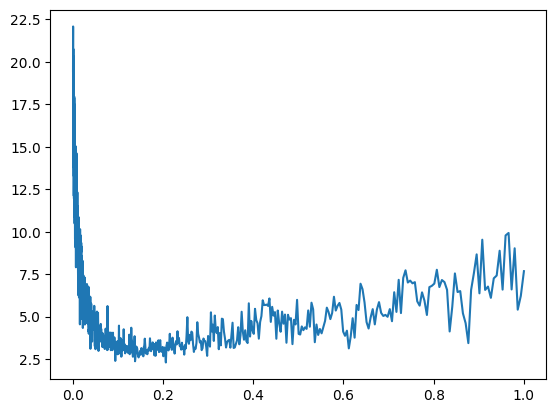

In [114]:
plt.plot(lri, lossi);
# хороший learning rate должен быть где-то в минимуме, где обучение стабильное

In [115]:
# поменяем обучение, записывая значение экспоненты learning rate,а не самого learning rate
# перезапустим все
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2) , generator=g)  # embeddings
W1 = torch.randn((6, 100) , generator=g)  # weights of 1 layer
b1 = torch.randn(100 , generator=g)  # bias of 1 layer
W2 = torch.randn((100, 27) , generator=g)  # weights of 2 layer
b2 = torch.randn(27 , generator=g)  # bias of 2 layer
parameters = [C, W1, b1, W2, b2]  # all the parameters

for p in parameters:
    p.requires_grad = True

# попробуем менять его динамически
lri = []
lossi = []
for i in range(1000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))
    
    # forward pass
    emb = C[X[ix]]  # [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # [32, 100]
    logits = h @ W2 + b2  # [32, 27]
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    lr = lrs[i]
    loss.backward()
    # update
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

18.922958374023438
15.161115646362305
20.346410751342773
21.387147903442383
21.120615005493164
20.17994499206543
19.975597381591797
17.44349479675293
19.09926414489746
21.295658111572266
18.80937385559082
19.80636215209961
21.223827362060547
18.463363647460938
21.661121368408203
18.712589263916016
19.250808715820312
20.597291946411133
17.39325523376465
19.674776077270508
18.014698028564453
17.725231170654297
20.74742889404297
15.942336082458496
15.61710262298584
14.471057891845703
15.886826515197754
20.63491439819336
16.961992263793945
16.868555068969727
19.278905868530273
18.317989349365234
19.060277938842773
17.815792083740234
20.81859588623047
16.740951538085938
19.277616500854492
18.120073318481445
14.194348335266113
18.941055297851562
18.199825286865234
18.129928588867188
18.3452091217041
21.40641975402832
20.643253326416016
19.47430419921875
16.79874610900879
16.439321517944336
14.874894142150879
19.111331939697266
19.02054214477539
18.889720916748047
18.231664657592773
17.693155

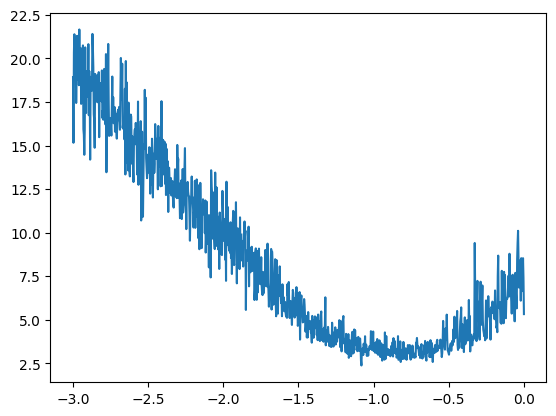

In [117]:
plt.plot(lri, lossi);
# в районе минимума хороший learning rate

In [127]:
# поменяем обучение, записывая значение экспоненты learning rate,а не самого learning rate
# перезапустим все
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2) , generator=g)  # embeddings
W1 = torch.randn((6, 100) , generator=g)  # weights of 1 layer
b1 = torch.randn(100 , generator=g)  # bias of 1 layer
W2 = torch.randn((100, 27) , generator=g)  # weights of 2 layer
b2 = torch.randn(27 , generator=g)  # bias of 2 layer
parameters = [C, W1, b1, W2, b2]  # all the parameters

for p in parameters:
    p.requires_grad = True
    
lr = 0.1
for i in range(50000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))
    
    # forward pass
    emb = C[X[ix]]  # [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # [32, 100]
    logits = h @ W2 + b2  # [32, 27]
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None

    # lr = lrs[i]
    
    # иногда делают обрезание learning rate после определенного количества итераций
    if i == 40000:
        lr /= 10
    loss.backward()
    # update
    for p in parameters:
        p.data += -lr * p.grad

    # # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

In [128]:
# посчитаем итоговый лосс
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3686, grad_fn=<NllLossBackward0>)

In [129]:
# лосс конечно маленький, но при достаточно сильной модели мы можем столкнуться в переобучением

# Разбиение данных на несколько частей

In [130]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [133]:
# построим датасет
def build_dataset(words):
    block_size = 3  # длина контекста: сколько букв учитывать при предсказании следующей буквы
    X, Y = [], []
    for w in words:
    
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]  # обрезаем и добавляем
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [138]:
# обучим с новыми данными, только train set
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2) , generator=g)  # embeddings
W1 = torch.randn((6, 100) , generator=g)  # weights of 1 layer
b1 = torch.randn(100 , generator=g)  # bias of 1 layer
W2 = torch.randn((100, 27) , generator=g)  # weights of 2 layer
b2 = torch.randn(27 , generator=g)  # bias of 2 layer
parameters = [C, W1, b1, W2, b2]  # all the parameters

for p in parameters:
    p.requires_grad = True

lr = 0.1
for i in range(50000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # forward pass
    emb = C[Xtr[ix]]  # [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # [32, 100]
    logits = h @ W2 + b2  # [32, 27]
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None

    # иногда делают обрезание learning rate после определенного количества итераций
    if i == 40000:
        lr /= 10
    loss.backward()
    # update
    for p in parameters:
        p.data += -lr * p.grad

In [139]:
print(loss.item())

1.9162719249725342


In [140]:
# посчитаем итоговый лосс, но уже используя валидационные данные
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3315, grad_fn=<NllLossBackward0>)

In [141]:
# посчитаем итоговый лосс, но уже используя тренировочные данные
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3256, grad_fn=<NllLossBackward0>)

In [142]:
# ошибки примерно одинаковые, значит сеть не переобучилась

In [155]:
# увеличим число параметров и посмотрим что получится
# обучим с новыми данными, только train set
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2) , generator=g)  # embeddings
W1 = torch.randn((6, 300) , generator=g)  # weights of 1 layer
b1 = torch.randn(300 , generator=g)  # bias of 1 layer
W2 = torch.randn((300, 27) , generator=g)  # weights of 2 layer
b2 = torch.randn(27 , generator=g)  # bias of 2 layer
parameters = [C, W1, b1, W2, b2]  # all the parameters

for p in parameters:
    p.requires_grad = True

lossi = []
stepi = []
lr = 0.1
for i in range(60000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # forward pass
    emb = C[Xtr[ix]]  # [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # [32, 300]
    logits = h @ W2 + b2  # [32, 27]
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None

    # иногда делают обрезание learning rate после определенного количества итераций
    if i == 40000:
        lr /= 10
    loss.backward()
    # update
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.item())

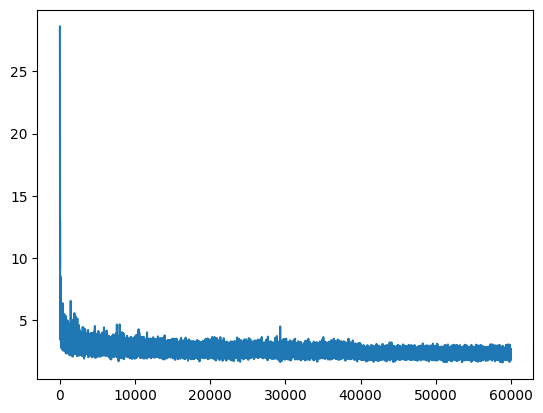

In [156]:
plt.plot(stepi, lossi);

In [157]:
# посчитаем итоговый лосс, но уже используя валидационные данные
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2985, grad_fn=<NllLossBackward0>)

In [158]:
# посчитаем итоговый лосс, но уже используя тренировочные данные
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2868, grad_fn=<NllLossBackward0>)

# Визуализация эмбеддингов

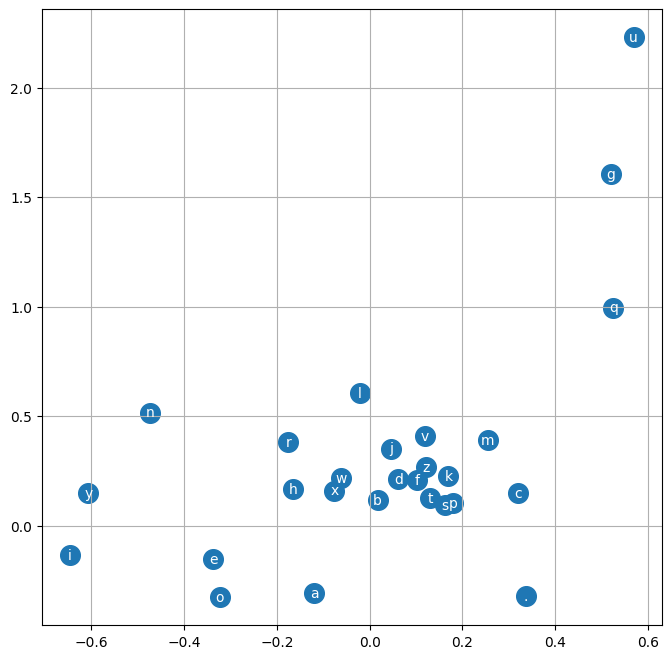

In [159]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')

plt.grid('minor')

In [160]:
# В прошлой части мы заметили, что увеличение размера скрытого слоя не дало никакого эффекта, попробуем увеличить размер эмбеддингов

In [169]:
# увеличим размер эмбеддингов и посмотрим что получится
# обучим с новыми данными, только train set
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10) , generator=g)  # embeddings
W1 = torch.randn((30, 200) , generator=g)  # weights of 1 layer
b1 = torch.randn(200 , generator=g)  # bias of 1 layer
W2 = torch.randn((200, 27) , generator=g)  # weights of 2 layer
b2 = torch.randn(27 , generator=g)  # bias of 2 layer
parameters = [C, W1, b1, W2, b2]  # all the parameters

for p in parameters:
    p.requires_grad = True

lossi = []
stepi = []
lr = 0.1
for i in range(150000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # forward pass
    emb = C[Xtr[ix]]  # [32, 3, 10]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # [32, 200]
    logits = h @ W2 + b2  # [32, 27]
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None

    # иногда делают обрезание learning rate после определенного количества итераций
    if i == 50000:
        lr /= 10
    loss.backward()
    # update
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

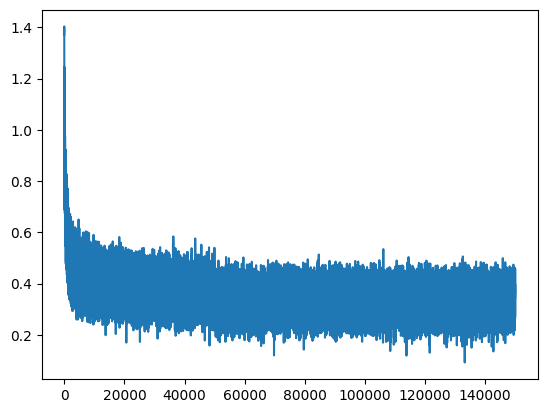

In [170]:
plt.plot(stepi, lossi);

In [171]:
# посчитаем итоговый лосс, но уже используя валидационные данные
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2031, grad_fn=<NllLossBackward0>)

In [172]:
# посчитаем итоговый лосс, но уже используя тренировочные данные
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1713, grad_fn=<NllLossBackward0>)

In [173]:
# в итоге мы получем лосс меньше, его можно еще пробовать уменьшать, меняя число слов (не 3, а, например, 4 и больше)
# меняя параметры сети и обучения

# Генерация такой моделью

In [174]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # сначала у нас только фиктивные буквы "..."
    while True:
        emb = C[torch.tensor([context])]  # [1, block_size, d]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mon.
aimyah.
keel.
nihayla.
rethr.
jendraeg.
adelyn.
elin.
shioren.
eden.
van.
narvelle.
malara.
nossebergiaghies.
kindreellionnieus.
kuya.
geder.
yarue.
els.
kaysh.
